<a href="https://colab.research.google.com/github/yahya010/DocClustering/blob/Tristan_Working/SeniorDesignCode_03_08_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 pip install -U sentence-transformers cleanlab hdbscan umap umap-learn[plot] wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 64.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.8 MB/s eta 0:00:00
  Pr

In [2]:
# IMPORTS

from cleanlab.outlier import OutOfDistribution
from enum import Enum
import os
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from PIL import Image
from seg_algorithm import get_optimal_splits, get_segmented_sentences
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
from umap.umap_ import INT32_MAX
from wordcloud import WordCloud
from gensim.scripts.glove2word2vec import glove2word2vec
import cleanlab
import hdbscan
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import sklearn.cluster as cluster
import string
import torch
import torch.nn.functional as F
import umap
import unicodedata
from gensim.models import KeyedVectors
from statistics import mean
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS
import csv
nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Constants
URL = "https://raw.githubusercontent.com/yahya010/DocClustering/main/Pres_Speeches/presidential_speeches.csv"
stop_words = set(stopwords.words('english')) # switched to sklearn as it is larger than nltk stopwords
dataset = pd.read_csv(URL)
p = 0.65 #increase p = no of segments decreases

# Initialization
SEPERATE_BY_PRES = False

# Pre-Processing
MIN_SENTENCE_WORDS = 5
PLOT_SPEECHLEN_HIST = True
MIN_SPEECH_SENTENCE_COUNT = 10 # 10 sentences needed for cleanlab embedding

# Cleanlab
OUTLIER_SCORE_CUTOFF = 0.5
Z_SCORE_CUTOFF = -1.501
PRINT_CLEANLAB_ANALYSIS = True


## REF: https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nlp_tf-idf_clustering.ipynb#scrollTo=EbAMAIFFV_xh

# List of Presidents
class PresidentIndex(Enum):
  George_Washington = 0
  John_Adams = 1
  Thomas_Jefferson = 2
  James_Madison = 3
  James_Monroe = 4
  John_Quincy_Adams = 5
  Andrew_Jackson = 6
  Martin_Van_Buren = 7
  William_Harrison = 8
  John_Tyler = 9
  James_Polk = 10
  Zachary_Taylor = 11
  Millard_Fillmore = 12
  Franklin_Pierce = 13
  James_Buchanan = 14
  Abraham_Lincoln = 15
  Andrew_Johnson = 16
  Ulysses_Grant = 17
  Rutherford_Hayes = 18
  James_Garfield = 19
  Chester_Arthur = 20
  Grover_Cleveland_1 = 21
  Benjamin_Harrison = 22
  Grover_Cleveland_2 = 23
  William_McKinley = 24
  Theodore_Roosevelt = 25
  William_Taft = 26
  Woodrow_Wilson = 27
  Warren_Harding = 28
  Calvin_Coolidge = 29
  Herbert_Hoover = 30
  Franklin_Roosevelt = 31
  Harry_Truman = 32
  Dwight_Eisenhower = 33 
  John_Kennedy= 34
  Lyndon_Johnson = 35
  Richard_Nixon = 36
  Gerald_Ford = 37
  James_Carter = 38
  Ronald_Reagan = 39
  George_Bush_SR = 40
  William_Clinton = 41
  George_Bush = 42
  Barack_Obama = 43
  Donald_Trump = 44

# Set Presidents to use
PRESIDENTS = [PresidentIndex.Ronald_Reagan, PresidentIndex.George_Bush_SR, PresidentIndex.William_Clinton, PresidentIndex.George_Bush, PresidentIndex.Barack_Obama, PresidentIndex.Donald_Trump];
PRESIDENT_NAMES = [n.name for n in PRESIDENTS]

# Get stopwords, stemmer and lemmatizer
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
general_stopwords = ENGLISH_STOP_WORDS  # note: sklearn has a longer list than nltk.corpus.stopwords.words('english')
additional_stopwords = []


# Get data samples and associated president
speeches = []
speech_classes = []

## TODO: VERIFY ALL PRES NAMES MATCH
# Tested: Washington, Lincoln

for index, row in dataset.iterrows():
  underscoreName = row['President'].replace(' ', '_')
  
  if underscoreName in PRESIDENT_NAMES:
    speeches.append(row['Transcript'])
    speech_classes.append(PresidentIndex[underscoreName].value)

In [4]:
def z_score(data):
    """Calculates the z-scores for a given dataset."""
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data - mean) / std_dev
    return z_scores

Number of Speeches Processed: 128
Filtered 0 speeches (under 10 sentences in total length)


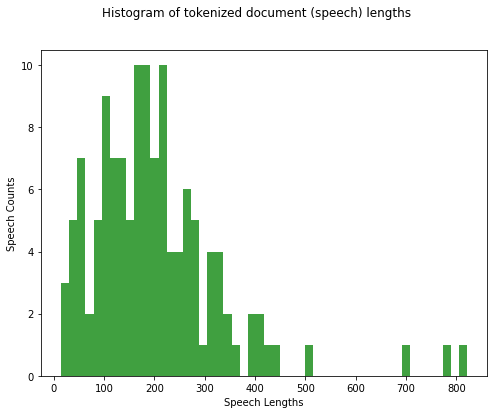

In [5]:
# Pre-Processing

pre_processed_speeches = []
list_token_lists = []


exclude = string.punctuation.replace(".", "")
exclude = exclude.replace("!", "")
exclude = exclude.replace("?", "")

# Pre-Processing Helpers
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")
  
def remove_misc(data):
  return data.replace('\n', '')

stop_words = set(stopwords.words('english'))
speech_lengths = []

for i, speech in enumerate(speeches):

  # Tokenize by sentence, then by lowercase word
  sent_count = 0
  pre_processed_speech_index = []

  for sentence in nltk.sent_tokenize(speech):
    token_list = []
    
    if len(nltk.word_tokenize(sentence)) < MIN_SENTENCE_WORDS:
      continue

    tokens = []
    sent_count += 1

    for word in nltk.word_tokenize(sentence):
      t = word.lower()
      t = remove_accents(t)
      t = remove_misc(t)
      t = str(t).translate(string.punctuation)
      t = t.translate(str.maketrans('', '', exclude))

      token_list.append(t)

    pre_processed_speech_index.append(' '.join(token_list)) # tokenized sentences
  
  if sent_count >= MIN_SPEECH_SENTENCE_COUNT:
    speech_lengths.append(sent_count)
    pre_processed_speeches.append(pre_processed_speech_index)
  
print(f'Number of Speeches Processed: {len(pre_processed_speeches)}')
print(f'Filtered {len(speeches) - len(pre_processed_speeches)} speeches (under 10 sentences in total length)')

df_speeches = pd.DataFrame(list_token_lists)

# Plot histogram of tokenized document lengths
if PLOT_SPEECHLEN_HIST:
  fig = plt.figure(figsize=(8,6))
  plt.suptitle("Histogram of tokenized document (speech) lengths")
  plt.xlabel("Speech Lengths")
  plt.ylabel("Speech Counts")
  n, bins, patches = plt.hist(speech_lengths, bins=50, density=False, facecolor='g', alpha=0.75)
  plt.show()

In [ ]:
# Cleanlab Score and Filter
# Filters unrelated sentences from each individual speech

# Filtered speeches = list of every useful sentence across every speech of the selected president(s)
post_cleanlab_speeches = []
post_cleanlab_sentences = []

all_cleanlab_scores = []

# Embedding and outlier removal
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

filtered_sent_percentages = []

for i, speech in enumerate(pre_processed_speeches):
  try:
    ood = OutOfDistribution()
    original_embeddings = model.encode(speech)
    train_outlier_scores = ood.fit_score(features=original_embeddings)
    # get outlier id's for sentences with outlier scores below cutoff value
    outlier_ids = [i for i, outlier_score in enumerate(train_outlier_scores) if outlier_score < OUTLIER_SCORE_CUTOFF]

    if PRINT_CLEANLAB_ANALYSIS:
      filtered_sentences = [s for i, s in enumerate(speech) if i in outlier_ids]
      filtered_percent = round((len(filtered_sentences) / len(speech)) * 100) 
      filtered_sent_percentages.append(filtered_percent)

      # Metrics
      
      average_cleanlab_score = float(np.mean(train_outlier_scores))
      variance_cleanlab_score = float(sum((x - average_cleanlab_score)**2 for x in train_outlier_scores) / (len(train_outlier_scores) - 1))
      std_cleanlab_score = float(np.sqrt(variance_cleanlab_score))
      min_cleanlab_score = float(min(train_outlier_scores))
      max_cleanlab_score = float(max(train_outlier_scores))

      all_cleanlab_scores.extend(train_outlier_scores)
      
      print(f'Speech: {i}')
      print("Cleanlab Metrics:")
      print(f'  Percent Sentences Filtered: {filtered_percent}% out of {len(speech)} Sentences')
      print(f'  Average: {round(average_cleanlab_score, 3)}')
      print(f'  Variance: {round(variance_cleanlab_score, 3)}')
      print(f'  STDev: {round(std_cleanlab_score, 3)}')
      print(f'  Min: {round(min_cleanlab_score, 3)}')
      print(f'  Max: {round(max_cleanlab_score, 3)}')
      print("Filtered Sentences:")
      for i, s in enumerate(filtered_sentences):
        print(f'  {i}: {s}')
      print("\n\n")

    speech_cleanlab = [s for i, s in enumerate(speech) if i not in outlier_ids]

    post_cleanlab_speeches.append(speech_cleanlab)

    for sentence in speech_cleanlab:
      post_cleanlab_sentences.append(sentence)
  except:
    continue

print(f'Cleanlab score: {all_cleanlab_scores}')

filtered_speech_embeddings = model.encode(post_cleanlab_sentences) # embedding

# if PRINT_CLEANLAB_ANALYSIS:
#   # print(f'Unfiltered Speech Shape: {model.encode(pre_processed_speeches).shape}') vcc
#   print(f'Filtered Speech Shape: {filtered_speech_embeddings.shape}')
#   print(f'Filtered Speech Shape Z Score: {filtered_speech_embeddings_z_score.shape}')
#   print(f'Average percentage of filtered sentences per speech (cutoff value  of {OUTLIER_SCORE_CUTOFF}): {sum(filtered_sent_percentages) / len(filtered_sent_percentages)}')
#   print(f'Average percentage of filtered z score sentences per speech (cutoff value  of {Z_SCORE_CUTOFF}): {sum(filtered_sent_percentages_z_score) / len(filtered_sent_percentages_z_score)}')

Fitting OOD estimator based on provided features ...
Speech: 0
Cleanlab Metrics:
  Percent Sentences Filtered: 17% out of 204 Sentences
  Average: 0.544
  Variance: 0.002
  STDev: 0.042
  Min: 0.417
  Max: 0.642
Filtered Sentences:
  0: thank you very much 
  1: thank you and good evening 
  2: the sponsor has been identified  but unlike most television programs  the performer has nt been provided with a script 
  3: i recently have seen fit to follow another course 
  4: not too long ago  two friends of mine were talking to a cuban refugee  a businessman who had escaped from castro  and in the midst of his story one of my friends turned to the other and said   we do nt know how lucky we are  and the cuban stopped and said   how lucky you are 
  5: but they ve been a little more explicit in the past and among themselves  and all of the things i now will quote have appeared in print 
  6: these are not republican accusations 
  7: we have so many people who ca nt see a fat man standing 

In [7]:
      all_z_scores = z_score(all_cleanlab_scores)
      average_cleanlab_score = float(np.mean(all_cleanlab_scores))
      variance_cleanlab_score = float(sum((x - average_cleanlab_score)**2 for x in all_cleanlab_scores) / (len(all_cleanlab_scores) - 1))
      std_cleanlab_score = float(np.sqrt(variance_cleanlab_score))
      min_cleanlab_score = float(min(all_cleanlab_scores))
      max_cleanlab_score = float(max(all_cleanlab_scores))
      average_z_score = float(np.mean(all_z_scores))
      variance_z_score = float(sum((x - average_z_score)**2 for x in all_z_scores) / (len(all_z_scores) - 1))
      std_z_score = float(np.sqrt(variance_z_score))
      min_z_score = float(min(all_z_scores))
      max_z_score = float(max(all_z_scores))
      print("Cleanlab Metrics:")
      print(f'  Average: {round(average_cleanlab_score, 3)}')
      print(f'  Variance: {round(variance_cleanlab_score, 3)}')
      print(f'  STDev: {round(std_cleanlab_score, 3)}')
      print(f'  Min: {round(min_cleanlab_score, 3)}')
      print(f'  Max: {round(max_cleanlab_score, 3)}')
      print("Cleanlab with Z Score Metrics:")
      print(f'  Average: {round(average_z_score, 3)}')
      print(f'  Variance: {round(variance_z_score, 3)}')
      print(f'  STDev: {round(std_z_score, 3)}')
      print(f'  Min: {round(min_z_score, 3)}')
      print(f'  Max: {round(max_z_score, 3)}')

NameError: ignored

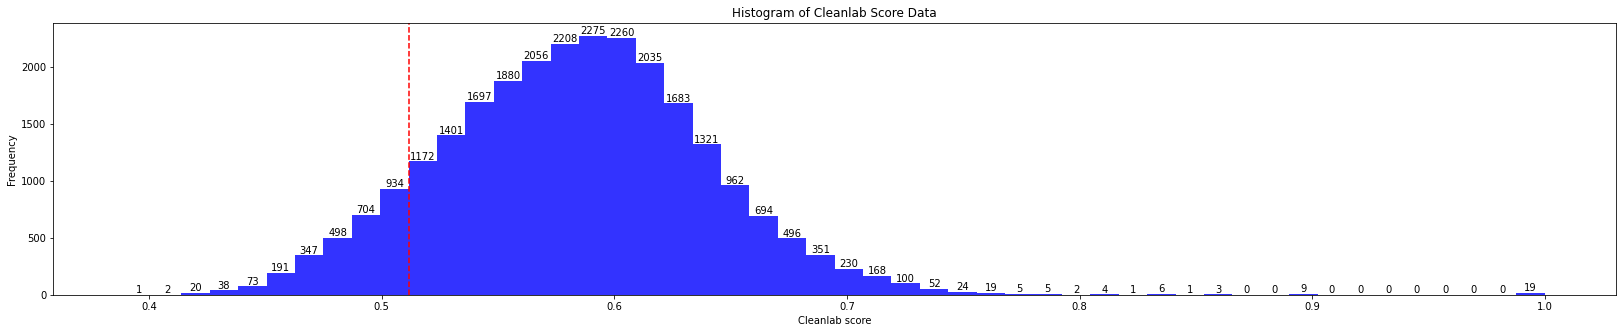

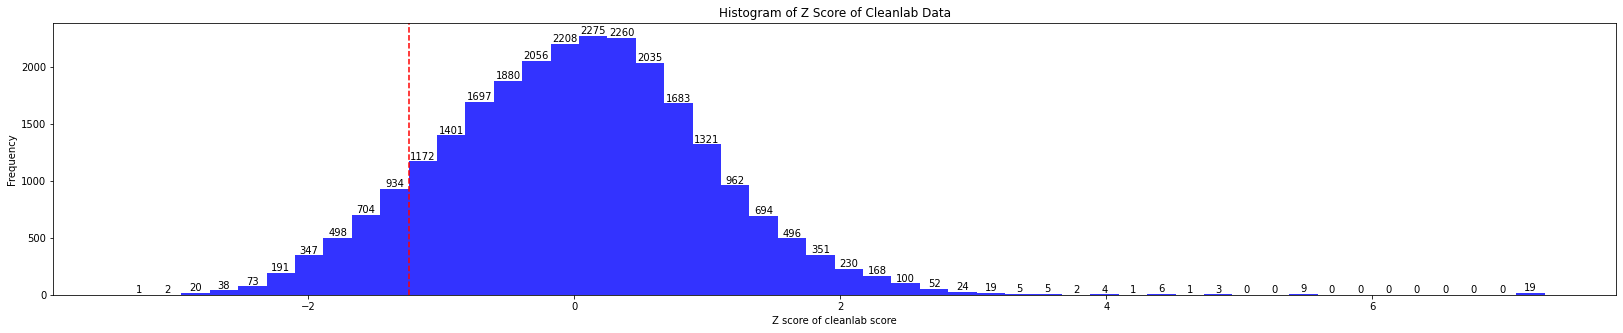

Cleanlab
  Smallest Cleanlab Number Score: 0.5
  Percent Filtered Out: 7.4%
Z Score
  Smallest Z Score Number Score: -1.447
  Percent Filtered Out: 7.4%


In [ ]:
# Cleanlab and Z score Histogram

cleanlab_histogram_cutoff = 0.5
num_bins = 50

# Cleanlab Histogram
fig = plt.figure(figsize=(28, 5))
n, bins, patches = plt.hist(all_cleanlab_scores, bins=num_bins, color='blue', alpha=0.8) # alpha is transparency of bars
sorted_data = np.sort(all_cleanlab_scores)
count = len([x for x in sorted_data if x < cleanlab_histogram_cutoff])
# val = np.min(sorted_data[n_smallest_num - 1])
idx = np.searchsorted(bins, cleanlab_histogram_cutoff, side='left')
x = bins[idx]
plt.axvline(x=x, color='red', linestyle='--')
plt.xlabel('Cleanlab score')
plt.ylabel('Frequency')
plt.title('Histogram of Cleanlab Score Data')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width()/2.0, patches[i].get_height(),
             int(n[i]), ha='center', va='bottom')
plt.show()

# Cleanlab with Z Score Histogram
fig = plt.figure(figsize=(28, 5))
n, bins, patches = plt.hist(all_z_scores, bins=num_bins, color='blue', alpha=0.8) # alpha is transparency of bars
sorted_data = np.sort(all_z_scores)
z_score_histogram_cutoff = np.min(sorted_data[count - 1])
z_score_count = len([x for x in sorted_data if x < z_score_histogram_cutoff])
idx = np.searchsorted(bins, z_score_histogram_cutoff, side='left')
x = bins[idx]
plt.axvline(x=x, color='red', linestyle='--')
plt.xlabel('Z score of cleanlab score')
plt.ylabel('Frequency')
plt.title('Histogram of Z Score of Cleanlab Data')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width()/2.0, patches[i].get_height(),
             int(n[i]), ha='center', va='bottom')
plt.show()
print(f'Cleanlab')
print(f'  Smallest Cleanlab Number Score: {cleanlab_histogram_cutoff}')
print(f'  Percent Filtered Out: {round(float((count/len(all_cleanlab_scores))*100),2)}%')

print(f'Z Score')
print(f'  Smallest Z Score Number Score: {round(float(z_score_histogram_cutoff),3)}')
print(f'  Percent Filtered Out: {round(float((z_score_count/len(all_z_scores))*100),2)}%')


In [ ]:
# PCA-95 Dimensionality Reduction
pca = PCA(n_components=0.95)
reduced_embedding = pca.fit_transform([f for f in filtered_speech_embeddings])  # filtered speech embedding is using post_cleanlab_sentences variable
print(reduced_embedding.shape)

(24027, 333)


In [ ]:
# UMAP Clustering
reducer = umap.UMAP(n_components=2)
sentences_embeddings_reduced = reducer.fit_transform(reduced_embedding)

# Apply KMeans clustering to the reduced embeddings
kmeans = KMeans(n_clusters=32)
kmeans.fit(reduced_embedding)

# Get the cluster labels for each sentence and plot
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_


# Storing data under each cluster
cluster_map = pd.DataFrame()
cluster_map['data_index'] = reduced_embedding
cluster_map['cluster'] = kmeans.labels_

# example: get all data points in cluster 3 cluster_map[cluster_map.cluster == 3]


plt.figure(figsize=(12, 6))
plt.title("Cluster Map: Cleanlab Filtered")
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels, cmap='jet', s=5) # s = dot size, cmap variables include cmap = 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# plt.xlim(6,14)  # Limits x axis range
# plt.ylim(0,10)  # Limits y axis range
plt.show()

print(reduced_embedding.shape)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: ignored

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


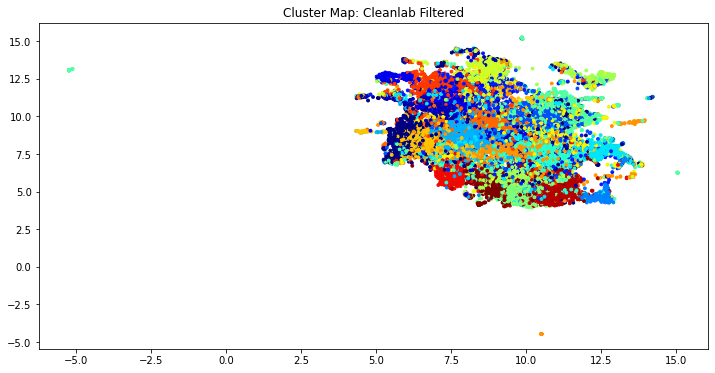

(24027, 333)


In [ ]:
# UMAP Clustering
reducer = umap.UMAP(n_components=2)
sentences_embeddings_reduced = reducer.fit_transform(reduced_embedding)

# Apply KMeans clustering to the reduced embeddings
kmeans = KMeans(n_clusters=21)
kmeans.fit(reduced_embedding)

# Get the cluster labels for each sentence and plot
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(12, 6))
plt.title("Cluster Map: Cleanlab Filtered")
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels, cmap='jet', s=8) # s = dot size, cmap variables include cmap = 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# plt.xlim(6,14)  # Limits x axis range
# plt.ylim(0,10)  # Limits y axis range
plt.show()

# Does the two dimensions just represent the visual cluster comparison? KMeans is nonlinear

print(reduced_embedding.shape)

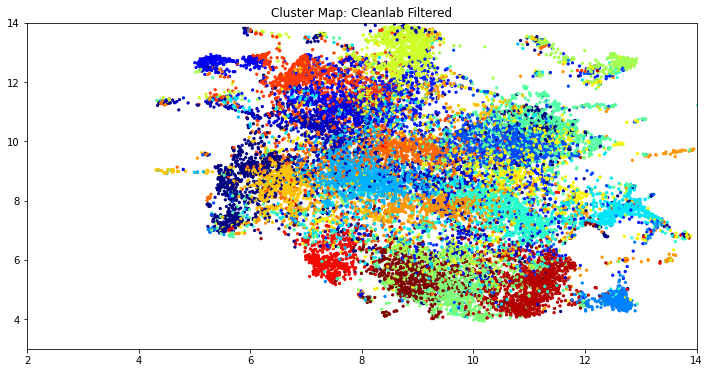

In [ ]:
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(12, 6))
plt.title("Cluster Map: Cleanlab Filtered")
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels, cmap='jet', s=5) # s = dot size, cmap variables include cmap = 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.xlim(2,14)  # Limits x axis range
plt.ylim(3,14)  # Limits y axis range
plt.show()

In [ ]:
# Segmentation
segmentation  = get_optimal_splits(filtered_speech_embeddings, p) # Splits.
segmented_txt = get_segmented_sentences(post_cleanlab_sentences, segmentation)
segment_list = []
for segment in segmented_txt:
    segment_list.append('Segment ' + str(segmented_txt.index(segment)) + ': ' + str(segment))

seglistDF = pd.DataFrame(segment_list)
seglistDF.to_csv('fullSegmentationList.csv')

In [ ]:
def squared_sum(x):
  """ return 3 rounded square rooted value """
  return round(np.sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

In [ ]:
def color_func(word=None, font_size=None,
                     position=None, orientation=None,
                     font_path=None, random_state=None):
    colors = [[4, 77, 82],
              [25, 74, 85],
              [82, 43, 84],
              [158, 48, 79]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

In [6]:
# Word Cloud
#Original method - probably using this

# Add in when stop words is needed
# additional_stopwords = ['may', 'will', 'good']
stop_words = set(stopwords.words('english'))
stop_words.update(additional_stopwords)

# List of tokenized sentences
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(post_cleanlab_sentences)

# Get the words and their tf-idf scores
feature_names = tfidf_vectorizer.get_feature_names_out()
scores = tfidf_matrix.toarray().mean(axis=0)

# Sort the words by their tf-idf scores
sorted_words = sorted(zip(feature_names, scores), key=lambda x: x[1])

lowest_tfidf_words = []
for word, score in sorted_words[:50]:
    lowest_tfidf_words.append(word)
#     print(f"{word}: {score:.4f}")
print(lowest_tfidf_words)

full_cluster_sentences = []

for i in range(kmeans.n_clusters): # 10 clusters now
    # Get the indices of sentences belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]
    cluster_sentences = [post_cleanlab_sentences[index] for index in cluster_indices]
    full_cluster_sentences.append(cluster_sentences)

    # Combine the sentences into a single string
    cluster_text = " ".join(cluster_sentences)
    cluster_text =" ".join([ word for word in cluster_text.split() if word.lower() not in lowest_tfidf_words and len(word)>2 and word.lower() not in stop_words])
    # Generate a word cloud from the cluster text


    # wordcloud = WordCloud(min_font_size=4, 
    #                       mask=mask,
    #                       width=mask.shape[1],
    #                       height=mask.shape[0],
    #                       stopwords=lowest_tfidf_words, 
    #                       background_color="white",
    #                       contour_width=1,
    #                       contour_color="black")
    wordcloud = WordCloud(max_words=120, width=800, height=800, min_font_size=10).generate(cluster_text)
    wordcloud.generate(cluster_text)

    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.title("Cluster".format(i))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

NameError: ignored

In [ ]:
print(kmeans.n_clusters)
fullClusterDF = pd.DataFrame(full_cluster_sentences)
sum = 0
for i in range(kmeans.n_clusters):
  print(len(full_cluster_sentences[i]))
  sum += len(full_cluster_sentences[i])

print(sum)
fullClusterDF.to_csv('full_cluster_sentences.csv')

32
1009
781
514
668
361
871
1011
579
673
867
791
450
499
716
596
729
888
801
566
1225
708
472
366
794
1062
919
912
821
1061
622
998
697
24027


In [ ]:
# Rishabhs
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import pandas as pd
from statistics import mean
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# pre_processed_speech_sentences

clusterStrings = full_cluster_sentences


if 'result' in globals():
  print('yes')
else:

  # Download GloVe embeddings
  
  #glove_input_file = '/content/glove.6B.300d.txt'
  word2vec_output_file = '/content/word2vec.txt'
  # The first step is to convert the GloVe file format to the word2vec file format. 
  # The only difference is the addition of a small header line. This can be done by calling the 
  # glove2word2vec() function.

  #glove2word2vec(glove_input_file, word2vec_output_file)
  model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
  # calculate: (king - man) + woman = ?
  result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
  print(result)


# Get the final coherence scores for each cluster

def calcFinalScores(coherenceScores, finalWeights):
  listScores = []
  for i in range(len(coherenceScores)):
    sum = 0
    for j in range(len(coherenceScores[i])):
      sum += finalWeights[i][j]*coherenceScores[i][j]
    listScores.append((sum*1000) / 45) # Multiply sum by 1000 to make scores more readable (this can be changed). Divide by 45 to get average. 
  return listScores


# Use temporary weights to get final weights. The weights will be finalized by normalizing them.

def calcFinalWeights(pairWeights):
  finalWeights = []
  for i in range(len(pairWeights)):
    curWeights = pairWeights[i]
    sumWeights = 0
    for j in range(len(curWeights)):
      # sumWeights = sumWeights + math.exp(curWeights[j])
      sumWeights = sumWeights + curWeights[j]
    tempFinalWeights = []
    for j in range(len(curWeights)):
      # tempFinalWeights.append(math.exp(curWeights[j]) / sumWeights)
      tempFinalWeights.append(curWeights[j] / sumWeights) # Normalize the weights
    finalWeights.append(tempFinalWeights)
  # sum = 0
  # for i in range(len(finalWeights[0])):
  #   sum = sum + finalWeights[1][i]
 
  return finalWeights

# This calculates the coherence score of each cluster
# The coherence is calculated by finding the pair-wise similarity between the top 10 words in the cluster.
# The top 10 words are determined using TF-IDF
# Final output will include intermediate scores and weights for the scores.
# Weigting is based on Zipf rank
#------

def calcCoherence1(clusterStrings):
  corpus = clusterStrings # set corpus as the list of clusters with corresponding texts as strings
  corpus = [' '.join(cluster) for cluster in clusterStrings]
  # Use TF-IDF
  vectorizer = TfidfVectorizer(stop_words=list(STOPWORDS), norm=None, smooth_idf=False) 
  X = vectorizer.fit_transform(corpus)
  idf = vectorizer.idf_
  idf = idf - 1
  countVectorizer = CountVectorizer(stop_words=list(STOPWORDS))
  tf = countVectorizer.fit_transform(corpus)
  tf = tf.toarray()
  tfidf = tf*idf

  lemmatizer = WordNetLemmatizer()
  coherenceScores = []
  pairWeights = []

  for i in range(len(clusterStrings)): # loop through all clusters

    df = pd.DataFrame(tfidf[i], index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
    dfs = df.sort_values('TF-IDF', ascending=False) 

    curList = dfs.index.to_list()
    curListLem = []
    curList10 = []

    # Get top 10 words (lemmatized)
    w = 0
    c = 0
    while c < 10:
      word = curList[w]
      curWord = lemmatizer.lemmatize(word)
      if curWord not in curListLem and curWord in model.vocab:
        curListLem.append(curWord)
        c = c + 1
      w = w + 1

    # Get pair-wise scores
    tempScore = []
    tempPairWeights = []
    for a in range(len(curListLem)):
      for b in range(a, len(curListLem)):
        if a != b:
          w1 = curListLem[a]
          w2 = curListLem[b]
          weight1 = list(model.vocab.keys()).index(w1) # Get Zipf rank of word 1
          weight2 = list(model.vocab.keys()).index(w2) # Get Zipf rank of word 2
          tempPairWeights.append(mean([weight1, weight2]))
          # tempPairWeigts.append(math.log(weight1, 10) + math.log(weight2, 10) / 2)
          tempScore.append(model.similarity(w1, w2))
    pairWeights.append(tempPairWeights)
    coherenceScores.append(tempScore)
  return [pairWeights, coherenceScores] # return list of weights and temporary scores
# wrapper function to calculate coherence scores

def calcCoherence(clusterStrings):
  pairWeights_and_coherenceScores1 = calcCoherence1(clusterStrings)
  pairWeights = pairWeights_and_coherenceScores1[0]
  coherenceScores1 = pairWeights_and_coherenceScores1[1]
  finalWeights = calcFinalWeights(pairWeights)
  finalScores = calcFinalScores(coherenceScores1, finalWeights)
  return finalScores


[('queen', 0.6713277101516724)]


In [ ]:
coherence_Scores = calcCoherence(full_cluster_sentences)
coherence_Scores_Average = float(np.mean(coherence_Scores))
print(coherence_Scores)
print(coherence_Scores.shape)
print(coherence_Scores_Average)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import pandas as pd


############ User Input #########################

wcFolder = # input path to folder to save word cloud images. Include '/' at end.

clusterStrings = full_cluster_sentences
'''
Enter your data here
load a list of your clusters.
Each item in the list is a concatenated string of all strings in the cluseter
Example:
    clusterStrings = [
                     ['Text1 in this cluster1. Text2 in this cluster1. Text3 in this cluter1'],
                     ['Text1 in this cluster2. Text2 in this cluster2. Text3 in this cluter2'],
                     ['Text1 in this cluster3. Text2 in this cluster3. Text3 in this cluter3'],
                     ]

'''

centroids = kmeans.cluster_centers_
'''
A list of centroids for each cluster
'''

clusterGroupsIndices = # load data Ryan
'''
A 2d list of indices corresponding to the original list of documents.
Each item is a list of indices belonging to the same cluster.
Example:
    clusterGroupsIndices = [
                            [20, 32, 522, 32, 23],
                            [3, 52, 64],
                            [78, 756, 3, 46, 786, 354, 657]
                           ]
'''

listOfDesc = post_cleanlab_sentences
'''
A list of documents that were clustered.
Example:
    listOfDesc = [
                 'Sentence in document1. Another sentence in document1.',
                 'Sentence in document2.',
                 'Sentence in document3. Another sentence in document3. Another sentence in document3.'
                 ]
'''
############ End User Input #########################                                    

corpus = clusterStrings



def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

# distance function Euclidean
def getMyDist(x, y):
  return np.linalg.norm(x - y)

# Word Cloud word sizes are based on TF-IDF of words in cluster
vectorizer = TfidfVectorizer(stop_words=STOPWORDS, norm=None, smooth_idf=False)
X = vectorizer.fit_transform(corpus)

#separate
idf = vectorizer.idf_
# print(idf - 1)
idf = idf - 1
countVectorizer = CountVectorizer(stop_words=STOPWORDS)
tf = countVectorizer.fit_transform(corpus)
tf = tf.toarray()

tfidf = tf*idf

distWeights = {}

lemmatizer = WordNetLemmatizer()
coherenceScores = []
pairWeights = []
temp = []
j = 1
for i in range(len(clusterStrings):
  distWeights = {}
  # df = pd.DataFrame(X[i].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
  df = pd.DataFrame(tfidf[i], index=vectorizer.get_feature_names(), columns=["TF-IDF"])
  dfs = df.sort_values('TF-IDF', ascending=False) 

  df_dict = df.to_dict()
  df_dict1 = df_dict['TF-IDF']
  df_dict1 = {key:val for key, val in df_dict1.items() if val != 0.0}

  # new weighting
  for wcWord in df_dict1:
    for sentenceIdx in range(len(clusterGroupsIndices[i])):
      sentence = listOfDesc[clusterGroupsIndices[i][sentenceIdx]]

      
      if findWholeWord(wcWord)(sentence):

        dist = getMyDist(centroids[i], descEmbeddings[clusterGroupsIndices[i][sentenceIdx]])
      
        if wcWord in distWeights:
          temp = distWeights[wcWord]
          temp.append(dist)
          distWeights[wcWord] = temp
        else:
          distWeights[wcWord] = [dist]
  for wcWord in df_dict1:
    if wcWord not in distWeights:
      distWeights[wcWord] = [1]

  for myWord in distWeights:
    distances = distWeights[myWord]
    sum = 0
    counter = 0
    for mydist in distances:
      # sum = sum + np.exp(-pow(mydist, 2) / (2*0.5))
      sum = sum + 1 / mydist
      counter = counter + 1
    distWeights[myWord] = sum

  for word in df_dict1:
    df_dict1[word] = distWeights[word] * df_dict1[word]
  
  if ' ' in clusterStrings[i]:
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(df_dict1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(wcFolder + 'cluster' + str(j) + '.png', dpi=600, bbox_inches='tight')
    plt.show()
  j = j + 1